In [1]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# Set the ticker symbol and time frame
ticker = "AAPL"
timeframe = "1Day"

# Set the start and end dates for the data
start_date = "2012-01-01T00:00:00-00:00"
end_date = "2022-01-01T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

# # Calculate the 3 period moving average of the close
# df['Mid']=(df['high']+df['low'])/2
# #df['Mid']=df['high']
# df['3MA'] = df['close'].rolling(3).mean()

# df['2MA'] = df['close'].rolling(2).mean()

# # Calculate the 10 period moving average of the close
# df['10MA'] = df['close'].rolling(10).mean()

# # Calculate the 20 period moving average of the close
# #df['20MA'] = df['close'].rolling(20).mean()

# df['Diff']=df['3MA']-df['10MA']

# df['3MASlope']=df['3MA'].pct_change()
# df['2MASlope']=df['2MA'].pct_change()
# df['10MASlope']=df['10MA'].pct_change()
# df['vwap']=df['vwap'].pct_change()
# df['CloseDiff3MA']=df['close']/df['3MA']
# df['open']=df['open'].pct_change().shift(-1)
# df['close']=df['close'].pct_change().shift(-1)
# df['Mid']=df['Mid'].pct_change()
# df=df.drop(columns=['high','low','volume','trade_count'])
# df['FutureMid']=df['Mid'].shift(-1)
           
# df["Signal"] = 0.0
           



In [12]:
df

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,105.35,105.368,102.00,351452,102.610,71935339,104.091749
2016-01-05 05:00:00+00:00,102.71,105.850,102.41,321365,105.750,58690536,103.400868
2016-01-06 05:00:00+00:00,100.70,102.370,99.87,409164,100.560,71079827,100.843959
2016-01-07 05:00:00+00:00,96.45,100.130,96.43,462836,98.680,85996453,98.011371
2016-01-08 05:00:00+00:00,96.96,99.110,96.76,419555,98.550,75066292,97.897369
...,...,...,...,...,...,...,...
2021-12-27 05:00:00+00:00,180.33,180.420,177.07,630113,177.085,80302069,179.120898
2021-12-28 05:00:00+00:00,179.29,181.330,178.53,631773,180.160,83078270,179.692940
2021-12-29 05:00:00+00:00,179.38,180.630,178.14,491795,179.330,66315539,179.450852


array([[<Axes: xlabel='timestamp'>],
       [<Axes: xlabel='timestamp'>]], dtype=object)

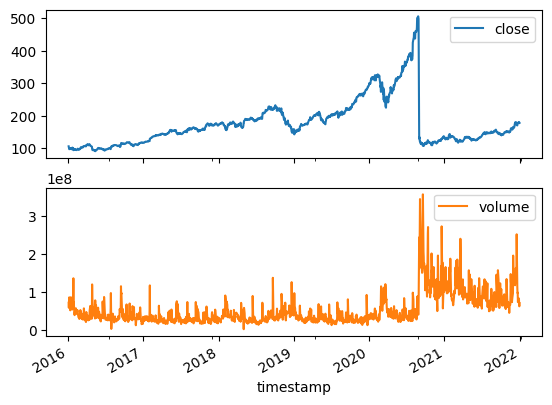

In [2]:
df[["close","volume"]].plot(subplots=True, layout=(2,1))

In [42]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    '''Test the null hypothesis of non-stationary time series data,
    if the pvalue is smaller than 0.05 threshold, reject the hypothesis'''
    result = adfuller(series, autolag='AIC', regression='ct')

    print('ADF Statistic: %f' % result[0])
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
check_stationarity(df['close'])

ADF Statistic: -3.010307
p-value: 0.1292222230318088
Critical Values:
	1%: -3.965
	5%: -3.413
	10%: -3.129
Non-stationary


In [ ]:
https://tsanggeorge.medium.com/a-semi-auto-way-to-determine-parameters-for-sarima-model-74cdee853080

In [45]:
import numpy as np
#taking first differencing
df['close_diff1']= df['close'].diff()
df['close_diff2']= df['close_diff1'].diff()
df['close_log']= np.log(df['close'])
df['close_growth']=df['close']*100
for close in ['close_diff1','close_diff2','close_log','close_growth']:
    print('For', close)
    check_stationarity(df[close].dropna())

For close_diff1
ADF Statistic: -16.536573
p-value: 0.0
Critical Values:
	1%: -3.965
	5%: -3.413
	10%: -3.129
Stationary
For close_diff2
ADF Statistic: -13.091640
p-value: 1.0413295434072412e-20
Critical Values:
	1%: -3.965
	5%: -3.413
	10%: -3.129
Stationary
For close_log
ADF Statistic: -2.449424
p-value: 0.3536918550189514
Critical Values:
	1%: -3.965
	5%: -3.413
	10%: -3.129
Non-stationary
For close_growth
ADF Statistic: -3.010307
p-value: 0.12922222303183323
Critical Values:
	1%: -3.965
	5%: -3.413
	10%: -3.129
Non-stationary


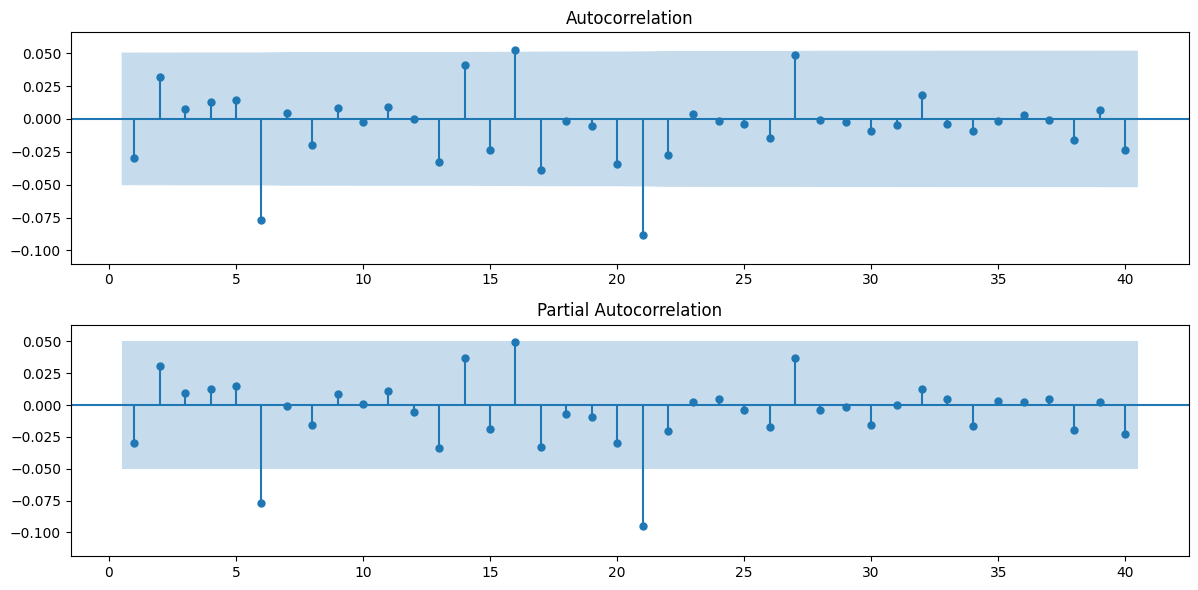

In [33]:
# overdifferenced since the first lag of acf plot is negatitve, 
# adding and moving averae to the model with order 2, since that is the lag where the acf plot cus off. 
import statsmodels.api as sm
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['close_diff1'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['close_diff1'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1])

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))
#p 2, d=1, q=2
plt.tight_layout()
plt.show()

In [ ]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = -1.0

'''for index, row in df.iterrows():
    if row["close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["close"] < 0:
        df.loc[index,"Signal"] = 0'''
        
'''for index, row in df.iterrows():
    if row["vwap"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["vwap"] < 0:
        df.loc[index,"Signal"] = 0.0'''
        
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["close"].shift(-1)

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(10)

In [ ]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

for column in lstColumns:
    display(df.hvplot.scatter(y='FutureMid',x=column))
    dfopt=df[['FutureMid',column]]
    display(dfopt.corr())

In [ ]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

In [ ]:
df

In [ ]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['10MASlope','2MASlope','CloseDiff3MA']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

display(X_test_scaled)

In [ ]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


In [ ]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()

model=logModel.fit(X_train_scaled, y_train)
log_pred=logModel.predict(X_test_scaled)

log_testing_report = classification_report(y_test, log_pred)

print(log_testing_report)


In [ ]:
4991/9151

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [ ]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    